# TEXT to SQL: Using ML to generate structured queries from Natural Language

Capstone Project by Alberto Marengo

NOTE: This is Jupyter Notebook 6 of 6 for this project. This notebook is about model evaluation and comparison.

This is a recap of the work done so far on the wikiSQL dataset in order to evaluate the models, comment the results and decide on step forwards. Below is the summary:

* Loaded wikiSQL datset into pandas
* Unpacked the encoded SQL queries into the different DataFrame columns. Five columns to predict (outputs):
    * SELECT
    * AGG (group by operator)
    * WHERE_0 (table column of WHERE statement)
    * WHERE_1 (operator of WHERE statement)
    * WHERE_2 (condition of WHERE statement)
* Reduced class dimensions and encoded the last column of the WHERE condition with entity recognition
* Used NLP to vectorize and tokenize the `question` and use the resulting matrix to predict the five different outputs
* Ran a `GridSearchCV` to optimize classifier and hyperparameters
* Modeled the problem (Multi-output multi-class) with three models:

    * `Classifier Chain` on imbalanced classes
    * RNN on imbalanced classes
    * RNN on weighted classes
    
We are going now to compare these three models to judge performances and decide on how to move forward.

We are going to load the data created in notebook 1, vectorize/tokenize the data as we did in notebook 2, load the three models we trained in notebooks 3 to 5 and plot the metrics on the same plot.

We are also going to encode the predicted queries into the original format in order to evaluate query execution and logistic form (using a python script provided with the wikiSQL dataset). 

Let's start loading the libraries!

In [1]:
import json
import joblib
import nltk
from nltk.corpus import stopwords 
import string

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer

## Load the data

We are going to load the data (only train and test set) from the `.csv` files we created in notebook 1. 

In [2]:
X_train = pd.read_csv('processed_data/X_train.csv', index_col=0, squeeze=True)
y_train = pd.read_csv('processed_data/y_train.csv', index_col=0, squeeze=True)

X_test = pd.read_csv('processed_data/X_test.csv', index_col=0, squeeze=True)
y_test = pd.read_csv('processed_data/y_test.csv', index_col=0)

## CountVectorizer

We are going to use `CountVectorizer` following the same procedure we used in notebook 2. For this reason we are not going to go into detail. 

In [3]:
stemmer = nltk.stem.PorterStemmer()
stemmer.stem('inventing')
ENGLISH_STOP_WORDS = stopwords.words('english')
question_words_list = ['what', 'which','who', 'whom','when', 'where', 'why', 'how', 'with', 
                       'for', 'between', 'into', 'to','from', 'all', 'any', 'both', 'each' ]
ENGLISH_STOP_WORDS = [word for word in ENGLISH_STOP_WORDS if word not in question_words_list]

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

bagofwords = CountVectorizer(min_df=5, tokenizer=my_tokenizer)

bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

C:\Users\maren\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


We are now scaling the data with the sklearn `Normalizer`.

In [4]:
normalizer = Normalizer()
normalizer.fit(X_train_transformed)

X_train_norm = normalizer.transform(X_train_transformed)
X_test_norm = normalizer.transform(X_test_transformed)

## Tensorflow Tokenizer

As we did in notebook 2, we are going to user tensorflow's `Tokenizer` on `X_train` to transform the text into word indexes. We are going to use a max number of words of 5,000.

In [5]:
# Instantiate the tokenizer
tokenizer = Tokenizer(char_level=False, lower=True, num_words=5000) 

# Fit the tokenizer to X_train
tokenizer.fit_on_texts(X_train)

# Transform X_train from words to indexes (sequences)
data = tokenizer.texts_to_sequences(X_train)

# Calculate the sequence length
seq_length = max([len(ls) for ls in data])

In [6]:
# Iterate over all the tokenized rows
for row in data:
    # Create list of `0`s of length  seq-length - row length
    app_ls = [0]*(seq_length - len(row))
    # Attach the string of `0`s to the row
    row.extend(app_ls)
        
X_tok = np.array(data)

In [7]:
# Transform X_test into tokens
data_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Iterate over all the tokenized rows
for row in data_test:
    if len(row) <= seq_length:
        # Create list of `0`s of length  seq-length - row length
        app_ls = [0]*(seq_length - len(row))
        # Attach the string of `0`s to the row
        row.extend(app_ls)
    else:
        del row[seq_length:]
X_test_tok = np.array(data_test)

## Load  Models

We are now going to load the trained `Classifier Chain` and get the predictions on `X_test`.

### Chain Classifier

In [9]:
# Load the model
chain_model = joblib.load("models/seq2sql_class.joblib")
chain_model

ClassifierChain(base_estimator=SVC(C=10, probability=True))

In [10]:
# Make prediciotns
chain_pred = chain_model.predict(X_test_norm)

### Accuracy

Let's now calculate the model accuracies on the five outputs on test set using sklearn `accuracy_score`.

In [11]:
acc_sel_c = accuracy_score(y_test.iloc[:, 0], chain_pred[:, 0])
acc_agg_c = accuracy_score(y_test.iloc[:, 1], chain_pred[:, 1])
acc_w0_c = accuracy_score(y_test.iloc[:, 2], chain_pred[:, 2])
acc_w1_c = accuracy_score(y_test.iloc[:, 3], chain_pred[:, 3])
acc_w2_c = accuracy_score(y_test.iloc[:, 4], chain_pred[:, 4])

We can then store the results in a Series where each row is an output accuracy.

In [12]:
# Create a Series with accuracies
acc_scores_c = pd.Series([acc_sel_c, acc_agg_c, acc_w0_c, acc_w1_c, acc_w2_c])
# Change index names as descriptors
acc_scores_c.index = ['acc_sel', 'acc_agg', 'acc_w0', 'acc_w1', 'acc_w2']
acc_scores_c

acc_sel    0.392011
acc_agg    0.876802
acc_w0     0.339557
acc_w1     0.914396
acc_w2     0.519464
dtype: float64

Let's transform the Series into a DataFrame where we will be able to append the accuracy score for all the models.

In [13]:
# Create the DataFrame from Series
acc_c_score_df = pd.DataFrame(acc_scores_c).reset_index()
# Change columns name
acc_c_score_df.rename(columns={'index': 'column', 0: 'acc_score'}, inplace=True)
# Add a column to describe from which model result comes from
acc_c_score_df['model'] = 'Chain Classifier'
acc_c_score_df

column  acc_score             model
0  acc_sel   0.392011  Chain Classifier
1  acc_agg   0.876802  Chain Classifier
2   acc_w0   0.339557  Chain Classifier
3   acc_w1   0.914396  Chain Classifier
4   acc_w2   0.519464  Chain Classifier

### F1 Score

Because of the class imbalance, let's also compare f1_score to check if it is a better metric then accuracy to score the model. We are going to follow the same process we just did above for accuracy.

In [14]:
f1_sel_c = f1_score(y_test.iloc[:, 0], chain_pred[:, 0], average='weighted')
f1_agg_c = f1_score(y_test.iloc[:, 1], chain_pred[:, 1], average='weighted')
f1_w0_c = f1_score(y_test.iloc[:, 2], chain_pred[:, 2], average='weighted')
f1_w1_c = f1_score(y_test.iloc[:, 3], chain_pred[:, 3], average='weighted')
f1_w2_c = f1_score(y_test.iloc[:, 4], chain_pred[:, 4], average='weighted')

We can then store the results in a Series where each row is an output f1_score.

In [15]:
# Create a Series with f1_scores
f1_scores_c = pd.Series([f1_sel_c, f1_agg_c, f1_w0_c, f1_w1_c, f1_w2_c])
# Change index names as descriptors
f1_scores_c.index = ['f1_sel', 'f1_agg', 'f1_w0', 'f1_w1', 'f1_w2']
f1_scores_c

f1_sel    0.385753
f1_agg    0.869944
f1_w0     0.324625
f1_w1     0.908716
f1_w2     0.492239
dtype: float64

Let's transform the Series into a DataFrame where we will be able to append the f1_score for all the models.

In [16]:
# Create the DataFrame from Series
f1_c_score_df = pd.DataFrame(f1_scores_c).reset_index()
# Change columns name
f1_c_score_df.rename(columns={'index': 'column', 0: 'f1_score'}, inplace=True)
# Add a column to describe from which model result comes from
f1_c_score_df['model'] = 'Chain Classifier'
f1_c_score_df

column  f1_score             model
0  f1_sel  0.385753  Chain Classifier
1  f1_agg  0.869944  Chain Classifier
2   f1_w0  0.324625  Chain Classifier
3   f1_w1  0.908716  Chain Classifier
4   f1_w2  0.492239  Chain Classifier

We are now going to load the trained base RNN model and get the predictions on `X_test`.

## RNN Base

We are going to load the model and set `compile=False` because we don't want to continue training the model, we just need to get the predictions.

In [17]:
# Load RNN model
RNN_base = load_model("models/00_Base/s2s", compile=False)
RNN_base

We can now get the probabilities for each class (result of `softmax` activation function in last dense layer) and each output.

In [18]:
RNN_test_pred = RNN_base.predict(X_test_tok)

To get the actual class prediction we just us the `np.argmax()` function that returns the class (argument) with higher probability.

In [19]:
rnn_test_pred_sel = np.argmax(RNN_test_pred[0], axis=1) 
rnn_test_pred_agg = np.argmax(RNN_test_pred[1], axis=1) 
rnn_test_pred_w0 = np.argmax(RNN_test_pred[2], axis=1) 
rnn_test_pred_w1 = np.argmax(RNN_test_pred[3], axis=1) 
rnn_test_pred_w2 = np.argmax(RNN_test_pred[4], axis=1) 

### Accuracy

Let's now calculate the model accuracies on the five outputs on test set using sklearn `accuracy_score`.

In [20]:
acc_sel_rnn = accuracy_score(y_test.iloc[:, 0], rnn_test_pred_sel)
acc_agg_rnn = accuracy_score(y_test.iloc[:, 1], rnn_test_pred_agg)
acc_w0_rnn = accuracy_score(y_test.iloc[:, 2], rnn_test_pred_w0)
acc_w1_rnn = accuracy_score(y_test.iloc[:, 3], rnn_test_pred_w1)
acc_w2_rnn = accuracy_score(y_test.iloc[:, 4], rnn_test_pred_w2)

We can then store the results in a Series where each row is an output accuracy.

In [21]:
# Create a Series with accuracies
acc_scores_rnn = pd.Series([acc_sel_rnn, acc_agg_rnn, acc_w0_rnn, acc_w1_rnn, acc_w2_rnn])
# Change index names as descriptors
acc_scores_rnn.index = ['acc_sel', 'acc_agg', 'acc_w0', 'acc_w1', 'acc_w2']
acc_scores_rnn

acc_sel    0.418238
acc_agg    0.873182
acc_w0     0.352829
acc_w1     0.954404
acc_w2     0.574014
dtype: float64

Let's transform the Series into a DataFrame where we will be able to append the accuracy score for all the models.

In [22]:
# Create the DataFrame from Series
acc_rnn_score_df = pd.DataFrame(acc_scores_rnn).reset_index()
# Change columns name
acc_rnn_score_df.rename(columns={'index': 'column', 0: 'acc_score'}, inplace=True)
# Add a column to describe from which model result comes from
acc_rnn_score_df['model'] = 'RNN Base Model'
acc_rnn_score_df

column  acc_score           model
0  acc_sel   0.418238  RNN Base Model
1  acc_agg   0.873182  RNN Base Model
2   acc_w0   0.352829  RNN Base Model
3   acc_w1   0.954404  RNN Base Model
4   acc_w2   0.574014  RNN Base Model

### F1 Score

Again let's also compare f1_score to check if it is a better metric then accuracy to score the model. We are going to follow the same process we just did above for accuracy.

In [23]:
f1_sel_rnn = f1_score(y_test.iloc[:, 0], rnn_test_pred_sel, average='weighted')
f1_agg_rnn = f1_score(y_test.iloc[:, 1], rnn_test_pred_agg, average='weighted')
f1_w0_rnn = f1_score(y_test.iloc[:, 2], rnn_test_pred_w0, average='weighted')
f1_w1_rnn = f1_score(y_test.iloc[:, 3], rnn_test_pred_w1, average='weighted')
f1_w2_rnn = f1_score(y_test.iloc[:, 4], rnn_test_pred_w2, average='weighted')

We can then store the results in a Series where each row is an output f1_score.

In [24]:
# Create a Series with f1_scores
f1_scores_rnn = pd.Series([f1_sel_rnn, f1_agg_rnn, f1_w0_rnn, f1_w1_rnn, f1_w2_rnn])
# Change index names as descriptors
f1_scores_rnn.index = ['f1_sel', 'f1_agg', 'f1_w0', 'f1_w1', 'f1_w2']
f1_scores_rnn

f1_sel    0.403929
f1_agg    0.872722
f1_w0     0.348358
f1_w1     0.951297
f1_w2     0.539441
dtype: float64

Let's transform the Series into a DataFrame where we will be able to append the f1_score for all the models.

In [25]:
# Create the DataFrame from Series
f1_rnn_score_df = pd.DataFrame(f1_scores_rnn).reset_index()
# Change columns name
f1_rnn_score_df.rename(columns={'index': 'column', 0: 'f1_score'}, inplace=True)
# Add a column to describe from which model result comes from
f1_rnn_score_df['model'] = 'RNN Base Model'
f1_rnn_score_df

column  f1_score           model
0  f1_sel  0.403929  RNN Base Model
1  f1_agg  0.872722  RNN Base Model
2   f1_w0  0.348358  RNN Base Model
3   f1_w1  0.951297  RNN Base Model
4   f1_w2  0.539441  RNN Base Model

Lastly, we are now going to load the trained weighted RNN model and get the predictions on `X_test`.

## RNN Weighted

In [26]:
RNN_weight = load_model("models/01_Class_Weights_25_epochs/s2sql", compile=False)
RNN_weight

We can now get the probabilities for each class (result of `softmax` activation function in last dense layer) and each output.

In [27]:
RNN_w_test_pred = RNN_weight.predict(X_test_tok)

To get the actual class prediction we just us the `np.argmax()` function that returns the class (argument) with higher probability.

In [28]:
rnn_w_test_pred_sel = np.argmax(RNN_w_test_pred[0], axis=1) 
rnn_w_test_pred_agg = np.argmax(RNN_w_test_pred[1], axis=1) 
rnn_w_test_pred_w0 = np.argmax(RNN_w_test_pred[2], axis=1) 
rnn_w_test_pred_w1 = np.argmax(RNN_w_test_pred[3], axis=1) 
rnn_w_test_pred_w2 = np.argmax(RNN_w_test_pred[4], axis=1) 

### Accuracy

Let's now calculate the model accuracies on the five outputs on test set using sklearn `accuracy_score`.

In [29]:
acc_sel_rnn_w = accuracy_score(y_test.iloc[:, 0], rnn_w_test_pred_sel)
acc_agg_rnn_w = accuracy_score(y_test.iloc[:, 1], rnn_w_test_pred_agg)
acc_w0_rnn_w = accuracy_score(y_test.iloc[:, 2], rnn_w_test_pred_w0)
acc_w1_rnn_w = accuracy_score(y_test.iloc[:, 3], rnn_w_test_pred_w1)
acc_w2_rnn_w = accuracy_score(y_test.iloc[:, 4], rnn_w_test_pred_w2)

We can then store the results in a Series where each row is an output accuracy.

In [30]:
# Create a Series with accuracies
acc_scores_rnn_w = pd.Series([acc_sel_rnn_w, acc_agg_rnn_w, acc_w0_rnn_w, acc_w1_rnn_w, acc_w2_rnn_w])
# Change index names as descriptors
acc_scores_rnn_w.index = ['acc_sel', 'acc_agg', 'acc_w0', 'acc_w1', 'acc_w2']
acc_scores_rnn_w

acc_sel    0.340128
acc_agg    0.833111
acc_w0     0.312186
acc_w1     0.917254
acc_w2     0.536864
dtype: float64

Let's transform the Series into a DataFrame where we will be able to append the accuracy score for all the models.

In [31]:
# Create the DataFrame from Series
acc_rnn_w_score_df = pd.DataFrame(acc_scores_rnn_w).reset_index()
# Change columns name
acc_rnn_w_score_df.rename(columns={'index': 'column', 0: 'acc_score'}, inplace=True)
# Add a column to describe from which model result comes from
acc_rnn_w_score_df['model'] = 'RNN Weighted Model'
acc_rnn_w_score_df

column  acc_score               model
0  acc_sel   0.340128  RNN Weighted Model
1  acc_agg   0.833111  RNN Weighted Model
2   acc_w0   0.312186  RNN Weighted Model
3   acc_w1   0.917254  RNN Weighted Model
4   acc_w2   0.536864  RNN Weighted Model

### F1 Score

Again let's also compare f1_score to check if it is a better metric then accuracy to score the model. We are going to follow the same process we just did above for accuracy.

In [32]:
f1_sel_rnn_w = f1_score(y_test.iloc[:, 0], rnn_w_test_pred_sel, average='weighted')
f1_agg_rnn_w = f1_score(y_test.iloc[:, 1], rnn_w_test_pred_agg, average='weighted')
f1_w0_rnn_w = f1_score(y_test.iloc[:, 2], rnn_w_test_pred_w0, average='weighted')
f1_w1_rnn_w = f1_score(y_test.iloc[:, 3], rnn_w_test_pred_w1, average='weighted')
f1_w2_rnn_w = f1_score(y_test.iloc[:, 4], rnn_w_test_pred_w2, average='weighted')

We can then store the results in a Series where each row is an output f1_score.

In [33]:
# Create a Series with f1_scores
f1_scores_rnn_w = pd.Series([f1_sel_rnn_w, f1_agg_rnn_w, f1_w0_rnn_w, f1_w1_rnn_w, f1_w2_rnn_w])
# Change index names as descriptors
f1_scores_rnn_w.index = ['f1_sel', 'f1_agg', 'f1_w0', 'f1_w1', 'f1_w2']
f1_scores_rnn_w

f1_sel    0.357715
f1_agg    0.848824
f1_w0     0.314191
f1_w1     0.925990
f1_w2     0.534667
dtype: float64

Let's transform the Series into a DataFrame where we will be able to append the f1_score for all the models.

In [34]:
# Create the DataFrame from Series
f1_rnn_w_score_df = pd.DataFrame(f1_scores_rnn_w).reset_index()
# Change columns name
f1_rnn_w_score_df.rename(columns={'index': 'column', 0: 'f1_score'}, inplace=True)
# Add a column to describe from which model result comes from
f1_rnn_score_df['model'] = 'RNN Base Model'
f1_rnn_w_score_df['model'] = 'RNN Weighted Model'
f1_rnn_w_score_df

column  f1_score               model
0  f1_sel  0.357715  RNN Weighted Model
1  f1_agg  0.848824  RNN Weighted Model
2   f1_w0  0.314191  RNN Weighted Model
3   f1_w1  0.925990  RNN Weighted Model
4   f1_w2  0.534667  RNN Weighted Model

## Summary Accuracy

Let's now put together the three DataFrames and plot the accuracies.

In [35]:
df_acc_score = pd.concat([acc_c_score_df, acc_rnn_score_df, acc_rnn_w_score_df], axis=0).reset_index(drop=True)

In [36]:
px.bar(df_acc_score, x='column', y='acc_score', color='model', barmode='group', title='Accuracy Score Distribution').update_layout(yaxis_title="Score")

As we can see from the bar plot above, the models' accuracies are very comparable. The base RNN seems to be a better predictor in almost all the outputs while, surprisingly, the weighted RNN is the least performing.

As we mentioned above, accuracy is not a good metric when in the presence of imbalance classes. This is why we are going to plot f1_score as well.

## Summary F1 scores

Let's now put together the three DataFrames and plot the f1_scores.

In [37]:
df_f1_score = pd.concat([f1_c_score_df, f1_rnn_score_df, f1_rnn_w_score_df], axis=0).reset_index(drop=True)

In [38]:
px.bar(df_f1_score, x='column', y='f1_score', color='model', barmode='group', title='F1 Score Distribution').update_layout(yaxis_title="Score")

Unfortunately, f1_scores don't seem to be better metrics for the problem. The f1_score of the three models are, again, very comparable. The base RNN is still the best performer while the `Classifier Chain` and the weighted RNN seem to have very similar scores.

Focusing on RNN. let's have a look again at the confusion matrices of the base vs. the weighted RNN and draw some conclusion.

## RNN Models Confusion Matrix

Let's now show both confusion sets (base and weighted RNN) of matrices and comment them.

In [39]:
# Make the list of the five predictions for base RNN
test_pred_list = [rnn_test_pred_sel, rnn_test_pred_agg, rnn_test_pred_w0, rnn_test_pred_w1, rnn_test_pred_w2]
# Create an empty dictionary
conf_mat_dict = {}

# Create a confusion matrix for each output
for i in range(len(test_pred_list)): 
    conf_mat = confusion_matrix(y_test.iloc[:, i], test_pred_list[i])
    # Append the matrix to the dictionary
    conf_mat_dict[i] = conf_mat

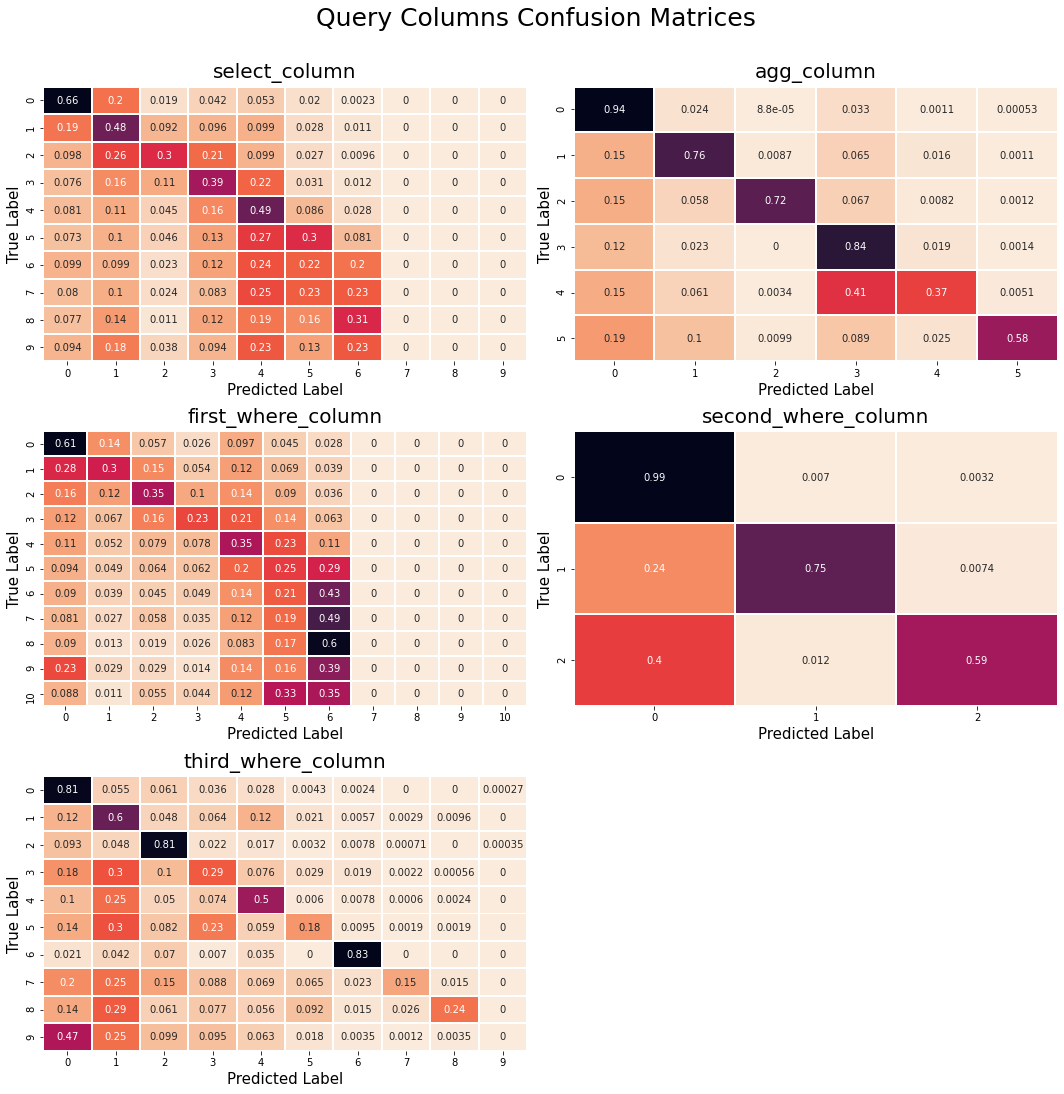

In [40]:
# Create the list of column names
columns = ['select_column', 'agg_column', 'first_where_column', 'second_where_column', 'third_where_column']
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Flatten the axes from a 3x2 to a 6x1
ax = ax.flatten()

# Plot the confusion matrices
for i in range(5):
    conf_mat = conf_mat_dict[i]
    # Normalize the confusion matrix along the 'predicted' columns
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_conf_mat,
                        annot=True,
                        cbar=False,
                        cmap="rocket_r",
                        linewidths=1, ax=ax[i]
                       )
    # Set the title, x and y labels
    ax[i].set_title(columns[i], size = 20,y=1.01)
    ax[i].set_xlabel("Predicted Label", size = 15)
    ax[i].set_ylabel("True Label", size = 15)

# Plot the title of the figure
fig.suptitle("Query Columns Confusion Matrices", size = 25, y=1.01)
fig.tight_layout()

# Delete the last subplot
fig.delaxes(ax[-1])
fig.savefig('export_figures/RNN_model_conf_mat.png', bbox_inches='tight')

In [41]:
# Make the list of the five predictions for the weighted RNN
test_pred_list = [rnn_w_test_pred_sel, rnn_w_test_pred_agg, rnn_w_test_pred_w0, rnn_w_test_pred_w1, rnn_w_test_pred_w2]

# Create an empty dictionary
conf_mat_dict = {}

# Create a confusion matrix for each output
for i in range(len(test_pred_list)): 
    conf_mat = confusion_matrix(y_test.iloc[:, i], test_pred_list[i])
    # Append the matrix to the dictionary
    conf_mat_dict[i] = conf_mat

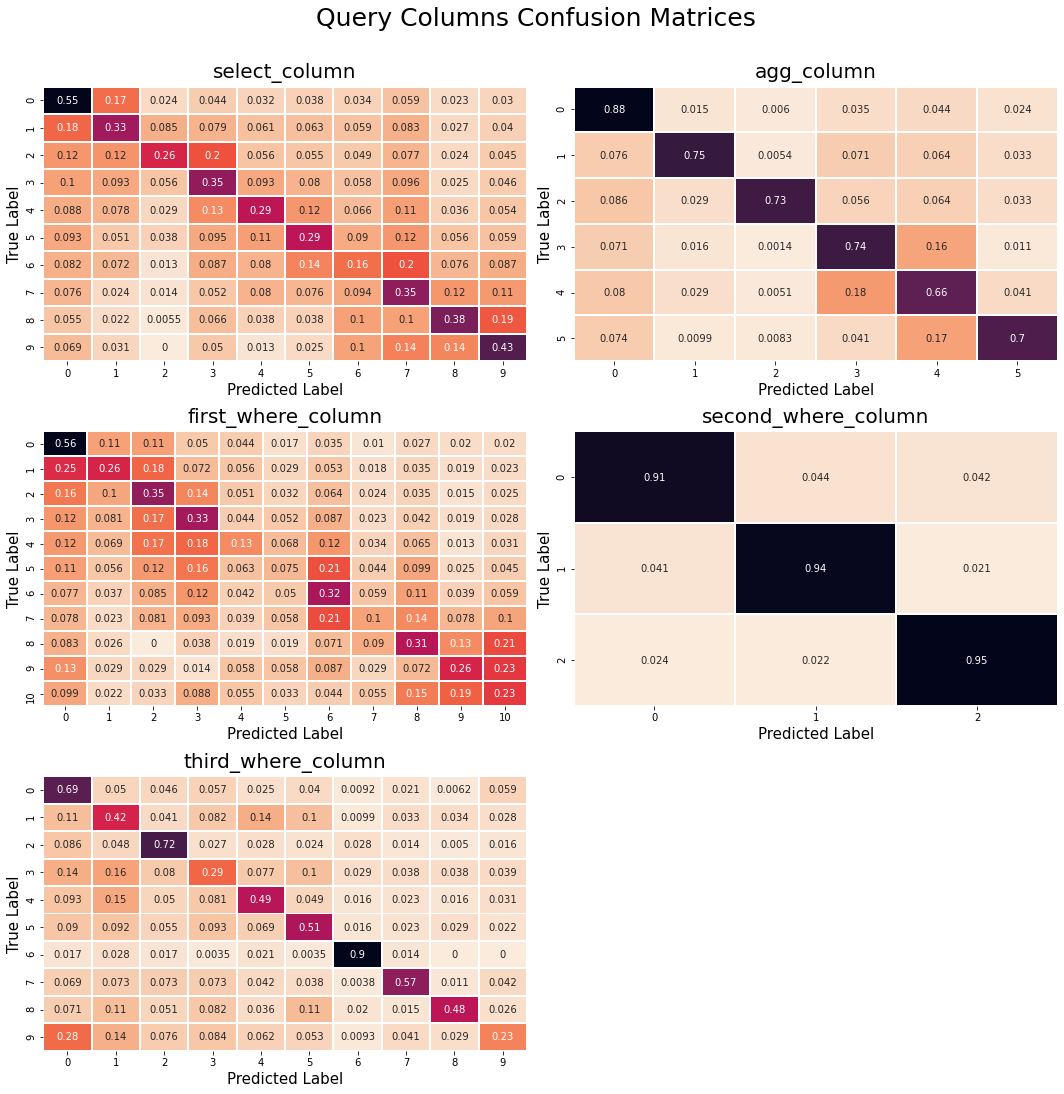

In [42]:
# Create the list of column names
columns = ['select_column', 'agg_column', 'first_where_column', 'second_where_column', 'third_where_column']
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Flatten the axes from a 3x2 to a 6x1
ax = ax.flatten()

# Plot the confusion matrices
for i in range(5):
    conf_mat = conf_mat_dict[i]
    # Normalize the confusion matrix along the 'predicted' columns
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_conf_mat,
                        annot=True,
                        cbar=False,
                        cmap="rocket_r",
                        linewidths=1, ax=ax[i]
                       )
    # Set the title, x and y labels
    ax[i].set_title(columns[i], size = 20,y=1.01)
    ax[i].set_xlabel("Predicted Label", size = 15)
    ax[i].set_ylabel("True Label", size = 15)

# Plot the title of the figure
fig.suptitle("Query Columns Confusion Matrices", size = 25, y=1.01)
fig.tight_layout()

# Delete the last subplot
fig.delaxes(ax[-1])
fig.savefig('export_figures/RNN_weighted_model_conf_mat.png', bbox_inches='tight')

Even though accuracies suggest that the base model has slightly better performance than the weighted RNN, we can see from the confusion matrices that the weighted model is overall doing better on all the classes. True predictions (diagonal) have the highest numbers in the matrix and we don't see classes that have zero values (not predicted).

The base classifier was better on some class but was performing quite badly on other. The weighted model is under-performing a bit on those "good" classes but is definitely over-performing on the very "bad" ones (that were zero).

A clear example of improvement is `second_where_column` that has only three classes (which represent the operators "=", "<" and ">"). The base model had 99% of true predictions (which is the recall of the model) on class 0, which is the most frequent. Because of the class imbalance had 75% and 59% of true predictions on class 1 and 2, respectively. On the other hand, the weighted model has 91%, 94% and 95% on class 0, 1 and 2 respectively. 

It looks like the weighted RNN model is actually performing better now on the less frequent classes.

## Combining RNN Models

We can also try to combine the predictions of the two RNN models to check if the resulting confusion matrices look like.

We are going to weight the probabilities from these two models giving 40% weight to the base model and 60% to the weighted one.

In [43]:
mean_sel = np.average([RNN_test_pred[0], RNN_w_test_pred[0]], axis=0, weights=[0.4, 0.6])
mean_agg = np.average([RNN_test_pred[1], RNN_w_test_pred[1]], axis=0, weights=[0.4, 0.6])
mean_w0 = np.average([RNN_test_pred[2], RNN_w_test_pred[2]], axis=0, weights=[0.4, 0.6])
mean_w1 = np.average([RNN_test_pred[3], RNN_w_test_pred[3]], axis=0, weights=[0.4, 0.6])
mean_w2 = np.average([RNN_test_pred[4], RNN_w_test_pred[4]], axis=0, weights=[0.4, 0.6])

To get the actual class prediction we just us the `np.argmax()` function that returns the class (argument) with higher probability.

In [44]:
stack_test_pred_sel = np.argmax(mean_sel, axis=1) 
stack_test_pred_agg = np.argmax(mean_agg, axis=1) 
stack_test_pred_w0 = np.argmax(mean_w0, axis=1) 
stack_test_pred_w1 = np.argmax(mean_w1, axis=1) 
stack_test_pred_w2 = np.argmax(mean_w2, axis=1) 

We can now calculate the confusion matrices for the combine RNN and plot them to compare with the previous ones.

In [45]:
# Make the list of the five predictions for the combined RNN
test_pred_list = [stack_test_pred_sel, stack_test_pred_agg, stack_test_pred_w0, stack_test_pred_w1, stack_test_pred_w2]

# Create an empty dictionary
conf_mat_dict = {}

# Create a confusion matrix for each output
for i in range(len(test_pred_list)): 
    conf_mat = confusion_matrix(y_test.iloc[:, i], test_pred_list[i])
    # Append the matrix to the dictionary
    conf_mat_dict[i] = conf_mat

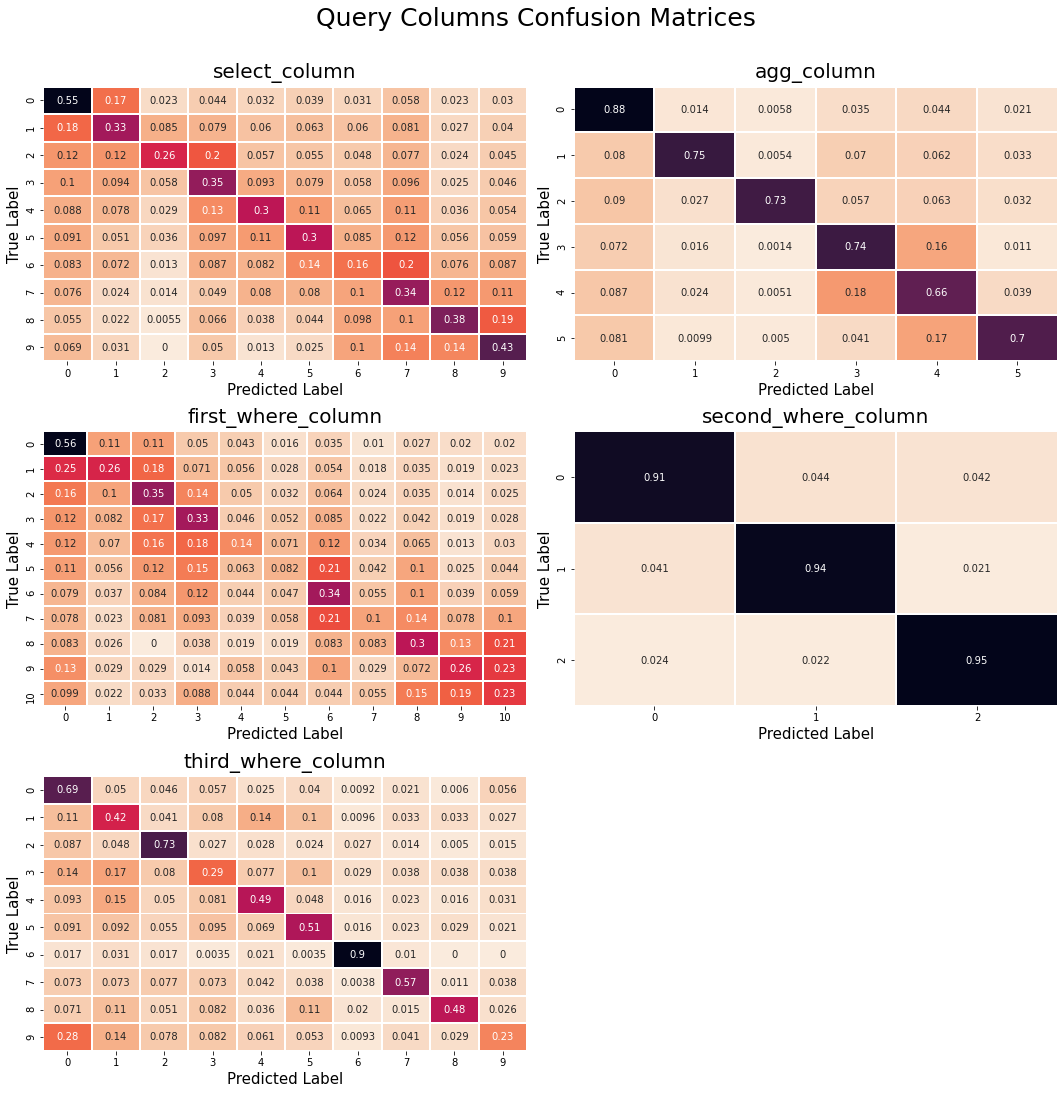

In [46]:
# Create the list of column names
columns = ['select_column', 'agg_column', 'first_where_column', 'second_where_column', 'third_where_column']
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Flatten the axes from a 3x2 to a 6x1
ax = ax.flatten()

# Plot the confusion matrices
for i in range(5):
    conf_mat = conf_mat_dict[i]
    # Normalize the confusion matrix along the 'predicted' columns
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_conf_mat,
                        annot=True,
                        cbar=False,
                        cmap="rocket_r",
                        linewidths=1, ax=ax[i]
                       )
    # Set the title, x and y labels
    ax[i].set_title(columns[i], size = 20,y=1.01)
    ax[i].set_xlabel("Predicted Label", size = 15)
    ax[i].set_ylabel("True Label", size = 15)

# Plot the title of the figure
fig.suptitle("Query Columns Confusion Matrices", size = 25, y=1.01)
fig.tight_layout()

# Delete the last subplot
fig.delaxes(ax[-1])

The confusion matrices for the combined RNN look very similar to the weighted RNN. Combing by averaging (weighted) the models doesn't seem to improve the performance. 

## Create and export the query

We are now going to encode out predictions (for all three models) the same way the data was provided, export the encoded queries as `.json` file and test them on the database.

Let's start creating a function that encodes back our results.

In [98]:
def make_query(row):
    # Makes a list of three WHERE condition statements
    cond_lst = list([row[2], row[3], row[4]])
    # Makes a list of a list, some of the original queries had multiple WHERE statements
    conds_lst = [cond_lst]
    # Build the query as dictionary
    query = {'sel': row[0], 'conds': conds_lst, 'agg': row[1]}
    # Returns query into a dictionary (one line of the json file)
    return {'query': query}

### Chain Classifier

Let's start with splitting the the five outputs (arrays) into five different files.

In [99]:
test_pred_sel_c = chain_pred[:, 0]
test_pred_agg_c = chain_pred[:, 1]
test_pred_w0_c = chain_pred[:, 2] 
test_pred_w1_c = chain_pred[:, 3]
test_pred_w2_c = chain_pred[:, 4]

We can now assign every output as the `value` of a dictionary.

In [100]:
columns_c = {'select_column': test_pred_sel_c,
           'agg_column': test_pred_agg_c,
           'w0_column': test_pred_w0_c,
           'w1_column': test_pred_w1_c,
           'w2_column': test_pred_w2_c
    
}

We can create the DataFrame where each output is a column.

In [101]:
chain_test_pred_df = pd.DataFrame(columns_c)
# Cast the number as integer
chain_test_pred_df = chain_test_pred_df.astype('int32')
chain_test_pred_df

select_column  agg_column  w0_column  w1_column  w2_column
0                  3           0          1          0          1
1                  4           0          0          0          1
2                  0           0          2          0          3
3                  0           3          2          0          1
4                  2           0          1          0          1
...              ...         ...        ...        ...        ...
15742              4           3          1          0          1
15743              2           0          4          0          0
15744              4           3          2          0          0
15745              4           0          3          0          0
15746              2           0          4          0          2

[15747 rows x 5 columns]

Finally, we can create a column `sql` which will be the encoded SQL query. We'll use the `lambda` function to `apply` the function we created above that generates the query.

In [102]:
chain_test_pred_df['sql'] = chain_test_pred_df.apply(lambda row: make_query(row), axis=1)

This is what the encoded predictions will look like. Very similar at what we saw in the original dataset.

In [103]:
chain_test_pred_df['sql']

0        {'query': {'sel': 3, 'conds': [[1, 0, 1]], 'ag...
1        {'query': {'sel': 4, 'conds': [[0, 0, 1]], 'ag...
2        {'query': {'sel': 0, 'conds': [[2, 0, 3]], 'ag...
3        {'query': {'sel': 0, 'conds': [[2, 0, 1]], 'ag...
4        {'query': {'sel': 2, 'conds': [[1, 0, 1]], 'ag...
                               ...                        
15742    {'query': {'sel': 4, 'conds': [[1, 0, 1]], 'ag...
15743    {'query': {'sel': 2, 'conds': [[4, 0, 0]], 'ag...
15744    {'query': {'sel': 4, 'conds': [[2, 0, 0]], 'ag...
15745    {'query': {'sel': 4, 'conds': [[3, 0, 0]], 'ag...
15746    {'query': {'sel': 2, 'conds': [[4, 0, 2]], 'ag...
Name: sql, Length: 15747, dtype: object

Let's export the column `sql` as a `.json` file now.

In [104]:
chain_test_pred_df['sql'].to_json('predictions/test_chain_pred.jsonl', orient='records', lines=True)

### RNN Base

We are going to follow the same procedure for the base RNN model.

We can now assign every output as the `value` of a dictionary.

In [105]:
columns = {'select_column': rnn_test_pred_sel,
           'agg_column': rnn_test_pred_agg,
           'w0_column': rnn_test_pred_w0,
           'w1_column': rnn_test_pred_w1,
           'w2_column': rnn_test_pred_w2
    
}

We can create the DataFrame where each output is a column.

In [106]:
RNN_test_pred_df = pd.DataFrame(columns)
RNN_test_pred_df

select_column  agg_column  w0_column  w1_column  w2_column
0                  2           0          0          0          4
1                  4           0          0          0          3
2                  0           0          4          0          5
3                  3           3          5          0          4
4                  4           0          2          0          1
...              ...         ...        ...        ...        ...
15742              4           3          0          1          2
15743              2           0          4          0          0
15744              4           3          1          0          1
15745              2           3          0          2          2
15746              0           0          4          0          2

[15747 rows x 5 columns]

Finally, we can create a column `sql` which will be the encoded SQL query. We'll use the `lambda` function to `apply` the function we created above that generates the query.

In [107]:
RNN_test_pred_df['sql'] = RNN_test_pred_df.apply(lambda row: make_query(row), axis=1)

This is what the encoded predictions will look like. Very similar at what we saw in the original dataset.

In [108]:
RNN_test_pred_df['sql']

0        {'query': {'sel': 2, 'conds': [[0, 0, 4]], 'ag...
1        {'query': {'sel': 4, 'conds': [[0, 0, 3]], 'ag...
2        {'query': {'sel': 0, 'conds': [[4, 0, 5]], 'ag...
3        {'query': {'sel': 3, 'conds': [[5, 0, 4]], 'ag...
4        {'query': {'sel': 4, 'conds': [[2, 0, 1]], 'ag...
                               ...                        
15742    {'query': {'sel': 4, 'conds': [[0, 1, 2]], 'ag...
15743    {'query': {'sel': 2, 'conds': [[4, 0, 0]], 'ag...
15744    {'query': {'sel': 4, 'conds': [[1, 0, 1]], 'ag...
15745    {'query': {'sel': 2, 'conds': [[0, 2, 2]], 'ag...
15746    {'query': {'sel': 0, 'conds': [[4, 0, 2]], 'ag...
Name: sql, Length: 15747, dtype: object

Let's export the column `sql` as a `.json` file now.

In [109]:
RNN_test_pred_df['sql'].to_json('predictions/test_RNN_pred.jsonl', orient='records', lines=True)

### RNN Weighted

We are going to follow the same procedure for the weighted RNN model.

We can now assign every output as the `value` of a dictionary.

In [110]:
columns_w = {'select_column': rnn_w_test_pred_sel,
           'agg_column': rnn_w_test_pred_agg,
           'w0_column': rnn_w_test_pred_w0,
           'w1_column': rnn_w_test_pred_w1,
           'w2_column': rnn_w_test_pred_w2
    
}

We can create the DataFrame where each output is a column.

In [111]:
RNN_w_test_pred_df = pd.DataFrame(columns_w)

Finally, we can create a column `sql` which will be the encoded SQL query. We'll use the `lambda` function to `apply` the function we created above that generates the query.

In [112]:
RNN_w_test_pred_df['sql'] = RNN_w_test_pred_df.apply(lambda row: make_query(row), axis=1)

Let's export the column `sql` as a `.json` file now.

In [113]:
RNN_w_test_pred_df['sql'].to_json('predictions/test_RNN_w_pred.jsonl', orient='records', lines=True)

## Execution Accuracy Vs. Logical Form Accuracy

The wikiSQL dataset comes with python script `evaluate.py` which can be ran from `Git Bash` according to the following:

`python evaluate.py source_file db_file pred_file`

positional arguments:
  * source_file  source file for the prediction
  * db_file      source database for the prediction
  * pred_file    predictions by the model

We are going to run the script on `test` set with the `test.db` file provided and the predictions that we just exported. Below is the screen shot.

<img src='figures/Final_results.jpg' width=1000 height=1000/>


The script returns two accuracies:

* **execution accuracy**: the number of queries that, when executed, result in the correct result 
* **logical form accuracy**: the number of queries that have exact string match with the ground truth query used to collect the paraphrase


Below we are going to input the above results into a DataFrame and plot the results.

In [63]:
chain_ex_acc = 0.0575*100
chain_lf_acc = 0.0003175*100
RNN_ex_acc = 0.0558*100
RNN_lf_acc = 0.0004445*100
RNN_w_ex_acc = 0.0301*100
RNN_w_lf_acc = 0.000254*100

final_acc_list = [chain_ex_acc, chain_lf_acc, RNN_ex_acc, RNN_lf_acc, RNN_w_ex_acc, RNN_w_lf_acc]

final_acc_df = pd.DataFrame(final_acc_list, columns=['score'])
final_acc_df['metric'] = ['ex_acc', 'lf_acc', 'ex_acc', 'lf_acc', 'ex_acc', 'lf_acc']
final_acc_df['model'] = ['Chain Classifier', 'Chain Classifier', 'RNN Base Model', 'RNN Base Model', 'RNN Weighted Model', 'RNN Weighted Model']
final_acc_df

score  metric               model
0  5.75000  ex_acc    Chain Classifier
1  0.03175  lf_acc    Chain Classifier
2  5.58000  ex_acc      RNN Base Model
3  0.04445  lf_acc      RNN Base Model
4  3.01000  ex_acc  RNN Weighted Model
5  0.02540  lf_acc  RNN Weighted Model

In [64]:
px.bar(final_acc_df, x='metric', y='score', color='model', barmode='group', title='Execution Accuracy Vs. Logical Form Accuracy').update_layout(yaxis_title="Score %")

The result above are quite surprising. The `Classifier Chain` has the highest execution accuracy of the three models, almost 6% of the queries predicted resulted in correct results. The weighted RNN has the lowest execution accuracy.

The fact that the execution accuracies are this low are due to the simplifications we made to the problem:

* class reduction in the outputs
* WHERE condition (third_where_column) approximated to its entity
* elimination of queries with multiple WHERE statements
* drop of queries with no WHERE statements

Because we did not decode the WHERE condition in the predictions, the only queries that are "correct" are the ones that refers to numeric WHERE conditions whereas all the strings are not matched.

Decoding the WHERE condition from their entities is going to be challenging and requires some thinking because somehow the original information got lost during encoding and it's going to be challenging to recover it. This will be a task moving forward.

The logical form accuracy is close to zero. Again, because of our simplifications we are not going to match the ground truth queries.

## Conclusions


We have seen that the problem is very complex and even though the SQL queries were encoded in a helpful way that allowed us to simplify the problem, we are still far from done. 

We saw that we oversimplified the problem reducing the number of classes, dropping the possibility of having a second WHERE statement, approximating the WHERE condition with an `Entity Recognition` and droppping queries with no WHERE statement.

Class imbalance plays a good role in misclassification and assigning class weights improve class true predictions (recall).

Overall, we have seen that more complex solutions (RNNs) don't lead to improvement in metrics. For a classification problem like this one the `Classifier Chain` is a good enough predictor, even though it takes a good amount of time to train.

At the time of writing, looking toward Demo Day updates, work in progress are underway to try to improve the performance of the weighted RNN by:

* simplifying the architecture (shallower models with less nodes)
* trying different learning rate schedulers and decay rate
* trying different batch sizes

So far not significant improvements have been made to the reported results in these notebooks.

Other work in progress are:

* make a function that decodes the entities in WHERE condition to improve execution accuracies
* make a script that returns an actual SQL query from the predictions
* make a web App that provides an example of the SQL queries given an example

We believe that, in order to tackle the problem, it will be necessary to change the approach as follow:

* Create a seq2seq model of type Encoder-Decoder that treats the output as tokens and not as multi-classes
* Include the column names in the features dataset
* Use a different tokenizer and/or encoders (BERT, RoBERTa, XLNet, ELMo, Glove, etc..) as mentioned [here](https://towardsdatascience.com/text-to-sql-learning-to-query-tables-with-natural-language-7d714e60a70d)
* Try implementing seq2SQL model that uses seq2seq and Reinforcement Learning (see link to paper in references)

The Capstone project was a great place for learning new tools and new skills from `Entity Recognition` to ` Classifier Chain` but also how to build a class to manage a multi-output Neural Network, create customized loss functions and callbacks.

## References

* [wikiSQL](https://github.com/salesforce/WikiSQL)
* [Seq2SQL: Generating Structured Queries from Natural Language using Reinforcement Learning](https://arxiv.org/pdf/1709.00103.pdf)
* [[Text-to-SQL] Learning to query tables with natural language](https://towardsdatascience.com/text-to-sql-learning-to-query-tables-with-natural-language-7d714e60a70d)
* [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
* [Building a multi-output Convolutional Neural Network with Keras](https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178)
* [Spider dataset](https://yale-lily.github.io/spider)
* [Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/)